In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Pokemon/pokemon.zip" -d "/content/sample_data"

Mounted at /content/drive
Archive:  /content/drive/My Drive/colab_datasets/pokemon.zip
   creating: /content/sample_data/pokemon/
 extracting: /content/sample_data/pokemon/1.png  
 extracting: /content/sample_data/pokemon/10.png  
 extracting: /content/sample_data/pokemon/100.png  
 extracting: /content/sample_data/pokemon/101.png  
  inflating: /content/sample_data/pokemon/102.png  
 extracting: /content/sample_data/pokemon/103.png  
 extracting: /content/sample_data/pokemon/104.png  
 extracting: /content/sample_data/pokemon/105.png  
  inflating: /content/sample_data/pokemon/106.png  
  inflating: /content/sample_data/pokemon/107.png  
  inflating: /content/sample_data/pokemon/108.png  
  inflating: /content/sample_data/pokemon/109.png  
 extracting: /content/sample_data/pokemon/11.png  
  inflating: /content/sample_data/pokemon/110.png  
 extracting: /content/sample_data/pokemon/111.png  
  inflating: /content/sample_data/pokemon/112.png  
  inflating: /content/sample_data/pokemon/

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten,
                                     MaxPooling2D)
import os
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot 
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

IMG_H = 64
IMG_W = 64
IMG_C = 3
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
from random import randint

In [ ]:
IMG_H = 64
IMG_W = 64
IMG_C = 3
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img)
    img = tf.image.resize_with_pad(img, IMG_H, IMG_W)
    #img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

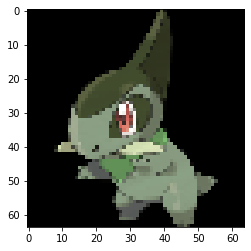

In [ ]:
image_names = list(filter(lambda string : string.endswith(".png"), os.listdir("/content/sample_data/pokemon")))
images = np.array([load_image("/content/sample_data/pokemon/" + x)[:,:,:3] for x in image_names])
plt.imshow(images[0] / 2 + 0.5)

BUFFER_SIZE = 60000
BATCH_SIZE = 32


image_labels = np.ones((len(images), 1))
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_folder = "/content/drive/MyDrive/Pokemon/Saves/"
l_rate_coef = 1/20
losses = [1 for _ in range(20)]
c = 1;

In [ ]:
def build_generator():
    model = tf.keras.Sequential(name="generator")
    model.add(Dense(4*4*512, use_bias=False, input_shape=(128,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512) 

    model.add(Conv2DTranspose(512, (5, 5), kernel_initializer=w_init, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 512)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(256, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    
    model.add(Conv2DTranspose(64, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

def build_discriminator():
    model = tf.keras.Sequential(name="discriminator")

    #model.add(MaxPooling2D((2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(Conv2D(64, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(256, (5, 5), kernel_initializer=w_init, strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.l_rate_coef = l_rate_coef
        self.gan_losses = [0, 0, 0]

        self.d_rounds = 2
        self.g_rounds = 1

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile(metrics=['accuracy'])
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn


    def train_step(self, data):
        real_images = data
        batch_size = tf.shape(real_images)[0]
        #m = tf.keras.metrics.CategoricalAccuracy()
        for _ in range(self.d_rounds):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                predictions = tf.cast(predictions, tf.float32)
                d1_loss = tf.reduce_sum(self.loss_fn(generated_labels, predictions)) * tf.cast((1 / batch_size),tf.float32)

            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                predictions = tf.cast(predictions, tf.float32)
                #d2_loss = self.loss_fn(labels, predictions)
                d2_loss = tf.reduce_sum(self.loss_fn(labels, predictions)) * tf.cast((1 / batch_size),tf.float32)


            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        for _ in range(self.g_rounds):
            ## Train the generator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            misleading_labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as gtape:
                predictions = self.discriminator(self.generator(random_latent_vectors))
                predictions = tf.cast(predictions, tf.float32)
                g_loss = self.loss_fn(misleading_labels, predictions)
                g_loss = tf.reduce_sum(self.loss_fn(misleading_labels, predictions)) * tf.cast((1 / batch_size),tf.float32)

            grads = gtape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        #d1_loss /= self.l_rate_coef
        #d2_loss /= self.l_rate_coef
        #c = c * 0.9 + (d1_loss + d2_loss) * 0.1
        #self.l_rate_coef = (d1_loss + d2_loss) * 1/20
        self.gan_losses = [d1_loss, d2_loss, g_loss]
        #print(l_rate)
        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss} #, "d1_acc" : d1_acc, "d2_acc": d2_acc, "g_acc": g_acc}



In [ ]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    plt.savefig(save_folder + 'image_epoch_{:04d}.png'.format(epoch)) 
    pyplot.close()

In [ ]:
def loss_plot(epoch, d1_losses, d2_losses, g_losses):
    fig, ax = plt.subplots()
    plt.plot(d1_losses, label='Discriminator on generated images', alpha=0.6)
    plt.plot(d2_losses, label='Discriminator on real images', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()

In [ ]:
def display_9_images_from_dataset(dataset):
        plt.figure(figsize=(9,9))
        subplot=331
        for i, image in enumerate(dataset):
            plt.subplot(subplot)
            plt.axis('off')
            plt.imshow(image.numpy().astype(np.uint8))
            subplot += 1
            if i==8:
              break
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

In [ ]:
def create(path,batch_size):
    filenames = tf.data.Dataset.list_files(path,seed=35155)
    def decode_jpeg_and_label(filename):
        bits = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(bits)
        image=tf.cast(image,tf.float32)
        image = (image - 127.5) / 127.5
        return image

    dataset = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)
    return dataset.batch(batch_size)

In [ ]:
LR_D = 0.00005
LR_G = 0.00005
EPOCHS = 500
BETA1 = 0.5
EPSILON = 0.00005

In [ ]:
batch_size = 64
latent_dim = 128
num_epochs = 1000
d1_losses, d2_losses, g_losses = [], [], []

#images_path = GCS_DS_PATH+'/pokemon_jpg/pokemon_jpg/*'
#path = glob("../input/pokemon-images-dataset/pokemon_jpg/pokemon_jpg/*")
#with strategy.scope():
d_model = build_discriminator()
g_model = build_generator()


start_epoch = 500 + 1

d_model_downgrade_epochs = 0

if start_epoch != 1:
  d_model.load_weights(save_folder + "d_model_" + str(start_epoch - 1 - d_model_downgrade_epochs) + ".h5")
  g_model.load_weights(save_folder + "g_model_" + str(start_epoch - 1) + ".h5")

d_model.summary()
g_model.summary()
#dataset=create(images_path,batch_size)

#with strategy.scope():
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1,reduction=tf.keras.losses.Reduction.NONE)

#with strategy.scope():
gan = GAN(d_model, g_model, latent_dim)
gan.compile(d_optimizer, g_optimizer, loss_obj)


images_dataset = train_dataset


n_samples = 25
with open("/content/drive/MyDrive/Pokemon/exapmles.txt", "r") as f:
    noise = np.fromfile(f).reshape(n_samples, latent_dim)
if start_epoch == 1:
    examples = g_model.predict(noise)
    save_plot(examples, 0, int(np.sqrt(n_samples)))

for epoch in range(start_epoch, start_epoch+EPOCHS):
    gan.fit(train_dataset, epochs=1)
    g_model.save(save_folder + "/g_model.h5")
    d_model.save(save_folder + "/d_model.h5")

    #if gan.gan_losses[0] + gan.gan_losses[1] < 0.8:
    #  gan.g_rounds += 1
    print(gan.g_rounds, gan.d_rounds)
    if epoch % 10 == 0:
        g_model.save(save_folder + "/g_model_" + str(epoch) + ".h5")
        d_model.save(save_folder + "/d_model_" + str(epoch) + ".h5")

    #n_samples = 25
    #with open("/content/drive/MyDrive/colab_datasets/pokemon/saves1/exapmles.txt", "r") as f:
    #  noise = np.fromfile(f).reshape(n_samples, latent_dim)
    examples = g_model.predict(noise)
    save_plot(examples, epoch, int(np.sqrt(n_samples)))

    d1_losses += [gan.gan_losses[0]]
    d2_losses += [gan.gan_losses[1]]
    g_losses += [gan.gan_losses[2]]
    #loss_plot(epoch, d1_losses, d2_losses, g_losses)
    #random_latent_vectors = tf.random.normal(shape=(5, self.latent_dim))
    



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
data = [[0.4129, 0.2697, 1.9400],
[0.2189, 0.3020, 2.8537],
[0.2311, 0.2932, 2.8010],
[0.2217, 0.2986, 2.8274],
[0.2333, 0.2729, 3.2974],
[0.2274, 0.2863, 2.8718],
[0.2248, 0.2801, 3.0482],
[0.2269, 0.2722, 3.0923],
[0.2212, 0.2675, 2.9986],
[0.2219, 0.2762, 2.8695],
[0.2226, 0.2663, 2.9841],
[0.2185, 0.2641, 2.8596],
[0.2219, 0.2723, 3.0030],
[0.2265, 0.2639, 2.9243],
[0.2294, 0.2657, 2.9411],
[0.2252, 0.2767, 2.8343],
[0.2223, 0.2769, 2.9245],
[0.2280, 0.2723, 2.8807],
[0.2397, 0.2716, 3.1514],
[0.2338, 0.2782, 2.8182],
[0.2326, 0.2703, 2.7507],
[0.2434, 0.2713, 2.9890],
[0.2375, 0.2795, 2.8345],
[0.2415, 0.2747, 2.6144],
[0.2364, 0.2727, 2.6167],
[0.2432, 0.2570, 2.9093],
[0.2436, 0.2627, 2.8412],
[0.2457, 0.2630, 2.7849],
[0.2608, 0.3013, 2.8966],
[0.2425, 0.2641, 2.7763],
[0.2582, 0.2680, 2.7816],
[0.2576, 0.2549, 2.6826],
[0.3341, 0.2814, 2.5877],
[0.2989, 0.2691, 2.6832],
[0.2679, 0.2537, 2.7860],
[0.2618, 0.2394, 2.8290],
[0.2483, 0.2401, 3.0269],
[0.2504, 0.2346, 2.7800],
[0.2576, 0.2286, 2.8392],
[0.2630, 0.2312, 2.9604],
[0.2637, 0.2370, 2.7864],
[0.2482, 0.2289, 2.8103],
[0.2524, 0.2268, 2.9909],
[0.2659, 0.2242, 3.0560],
[0.2667, 0.2260, 2.9946],
[0.2497, 0.2189, 2.9749],
[0.2469, 0.2209, 3.0537],
[0.2498, 0.2229, 3.0539],
[0.2495, 0.2228, 3.1212],
[0.2499, 0.2283, 3.0795],
[0.2617, 0.2192, 3.1165],
[0.2603, 0.2228, 2.9709],
[0.2696, 0.2207, 3.2218],
[0.2568, 0.2140, 3.0260],
[0.2493, 0.2144, 3.0655],
[0.2512, 0.2186, 3.1925],
[0.5558, 0.2690, 3.1271],
[0.2436, 0.2131, 2.9258],
[0.2505, 0.2141, 2.9996],
[0.2572, 0.2136, 2.9876],
[0.2446, 0.2109, 2.9619],
[0.2658, 0.2226, 3.2092],
[0.2463, 0.2119, 3.0735],
[0.2477, 0.2223, 3.0932],
[0.2525, 0.2127, 3.1671],
[0.2580, 0.2145, 3.2651],
[0.2482, 0.2132, 3.2784],
[0.2823, 0.2356, 3.1728],
[0.2411, 0.2134, 3.1149],
[0.2653, 0.2119, 3.1075],
[0.2495, 0.2195, 3.2914],
[0.2398, 0.2140, 3.1827],
[0.2802, 0.3543, 3.1113],
[0.2702, 0.2155, 3.1911],
[0.2353, 0.2096, 3.0531],
[0.2440, 0.2106, 3.0078],
[0.2463, 0.2089, 3.1941],
[0.2408, 0.2087, 3.1478],
[0.2389, 0.2087, 3.0374],
[0.2529, 0.2151, 3.2233],
[0.2406, 0.2159, 3.2341],
[0.2517, 0.2246, 3.2983],
[0.2393, 0.2174, 3.1598],
[0.2494, 0.2143, 3.4301],
[0.2368, 0.2177, 3.2074],
[0.2345, 0.2107, 3.1697],
[0.2380, 0.2196, 3.1845],
[0.2397, 0.2159, 3.1939],
[0.2375, 0.2133, 3.1776],
[0.2408, 0.2157, 3.2236],
[0.2440, 0.2175, 3.2553],
[0.2387, 0.2130, 3.2078],
[0.2421, 0.2164, 3.3114],
[0.2348, 0.2153, 3.1648],
[0.2477, 0.2194, 3.3186],
[0.2307, 0.2129, 3.1446],
[0.2400, 0.2267, 3.1561],
[0.2304, 0.2140, 3.1836],
[0.2334, 0.2152, 3.2074],
[0.2336, 0.2111, 3.3575],
[0.2370, 0.2172, 3.2367],
[0.2322, 0.2176, 3.2391],
[0.2320, 0.2160, 3.3940],
[0.2375, 0.2204, 3.2533],
[0.2267, 0.2132, 3.2880],
[0.2364, 0.2245, 3.3614],
[0.2392, 0.2238, 3.3414],
[0.2309, 0.2134, 3.3365],
[0.2372, 0.2221, 3.2876],
[0.2292, 0.2171, 3.2798],
[0.2374, 0.2262, 3.3786],
[0.2335, 0.2164, 3.2818],
[0.2227, 0.2142, 3.1924],
[0.2329, 0.2159, 3.1878],
[0.2270, 0.2110, 3.2638],
[0.2248, 0.2104, 3.1328],
[0.2257, 0.2223, 3.1759],
[0.2235, 0.2126, 3.1469],
[0.3637, 0.3776, 3.3974],
[0.2488, 0.2288, 3.3068],
[0.2313, 0.2169, 2.9940],
[0.2292, 0.2130, 3.1559],
[0.2252, 0.2092, 3.0789],
[0.2276, 0.2104, 3.1145],
[0.2259, 0.2081, 3.0766],
[0.2249, 0.2091, 3.1342],
[0.2301, 0.2156, 3.2425],
[0.2227, 0.2147, 3.2010],
[0.2279, 0.2138, 3.3323],
[0.2270, 0.2210, 3.1928],
[0.2253, 0.2131, 3.2161],
[0.2352, 0.2212, 3.3000],
[0.2198, 0.2083, 3.1924],
[0.2198, 0.2094, 3.2640],
[0.2224, 0.2137, 3.1189],
[0.2981, 0.2498, 3.5881],
[0.2210, 0.2115, 3.1992],
[0.2215, 0.2071, 3.1492],
[0.2164, 0.2075, 3.1200],
[0.2205, 0.2072, 3.1610],
[0.2198, 0.2089, 3.1283],
[0.2189, 0.2095, 3.1205],
[0.2225, 0.2103, 3.1758],
[0.2230, 0.2123, 3.1287],
[0.2194, 0.2072, 3.1241],
[0.2189, 0.2093, 3.0851],
[0.2236, 0.2158, 3.1859],
[0.2210, 0.2182, 3.1730],
[0.2536, 0.2564, 3.4549],
[0.2210, 0.2129, 3.2724],
[0.2139, 0.2062, 3.0601],
[0.2175, 0.2081, 3.0558],
[0.2178, 0.2066, 3.2178],
[0.2148, 0.2044, 3.1063],
[0.4114, 0.2676, 3.8761],
[0.2343, 0.2170, 3.3121],
[0.2212, 0.2088, 3.1324],
[0.2184, 0.2076, 3.0580],
[0.2191, 0.2073, 3.0377],
[0.2186, 0.2081, 3.0503],
[0.2201, 0.2062, 3.0809],
[0.2225, 0.2067, 3.1643],
[0.2188, 0.2055, 3.0551],
[0.2216, 0.2062, 3.2719],
[0.2216, 0.2045, 3.2599],
[0.5586, 0.2667, 3.7374],
[0.2588, 0.2310, 3.3851],
[0.2205, 0.2114, 3.0126],
[0.2221, 0.2085, 3.0259],
[0.2212, 0.2102, 3.0487],
[0.2183, 0.2066, 3.0865],
[0.2196, 0.2064, 3.0587],
[0.2224, 0.2078, 3.1642],
[0.2162, 0.2059, 3.0772],
[0.2198, 0.2109, 3.1064],
[0.2170, 0.2071, 3.1142],
[0.2221, 0.2098, 3.1925],
[0.2170, 0.2099, 3.1176],
[0.2150, 0.2064, 3.0334],
[0.2168, 0.2064, 3.1024],
[0.2227, 0.2205, 3.1205],
[0.2135, 0.2078, 3.0873],
[0.2163, 0.2099, 3.1363],
[0.2230, 0.2115, 3.3600],
[0.2127, 0.2079, 3.1756],
[0.2164, 0.2071, 3.2593],
[0.2156, 0.2108, 3.1719],
[0.2146, 0.2083, 3.1279],
[0.2248, 0.2227, 3.2558],
[0.2110, 0.2088, 3.1132],
[0.2116, 0.2076, 3.1406],
[0.2105, 0.2067, 3.0906],
[0.4044, 0.3042, 3.6643],
[0.2571, 0.2387, 3.7989],
[0.2151, 0.2140, 3.1134],
[0.2142, 0.2089, 3.0481],
[0.2143, 0.2076, 3.0197],
[0.2169, 0.2054, 3.0236],
[0.2161, 0.2052, 3.0412],
[0.2166, 0.2068, 3.0613],
[0.2150, 0.2040, 3.0224],
[0.2130, 0.2048, 2.9706],
[0.2155, 0.2073, 3.0123],
[0.2136, 0.2046, 3.0809],
[0.2147, 0.2099, 2.8815],
[0.3353, 0.2614, 3.6669],
[0.2113, 0.2070, 2.9932],
[0.2141, 0.2052, 3.0064],
[0.2137, 0.2041, 3.0910],
[0.2116, 0.2030, 3.0289],
[0.2100, 0.2016, 3.0271],
[0.2108, 0.2017, 3.0450],
[0.2113, 0.2018, 3.0844],
[0.2108, 0.2029, 3.0615],
[0.2110, 0.2040, 3.0555],
[0.2100, 0.2051, 3.0989],
[0.2141, 0.2029, 3.2278],
[0.2123, 0.2075, 3.0708],
[0.2133, 0.2103, 3.1376],
[0.2121, 0.2110, 3.1355],
[0.2135, 0.2071, 3.1833],
[0.2116, 0.2052, 3.0902],
[0.2124, 0.2081, 3.1587],
[0.2094, 0.2047, 3.0994],
[0.2122, 0.2051, 3.1440],
[0.2173, 0.2140, 3.2243],
[0.2149, 0.2110, 3.1411],
[0.2110, 0.2065, 3.0641],
[0.2631, 0.2424, 3.5269],
[0.3962, 0.2718, 3.8055],
[0.2214, 0.2162, 3.1259],
[0.2128, 0.2106, 3.0704],
[0.2106, 0.2102, 2.9679],
[0.2116, 0.2097, 3.0311],
[0.2413, 0.2153, 3.2629],
[0.2107, 0.2048, 3.0250],
[0.2132, 0.2071, 3.0241],
[0.2126, 0.2042, 3.0640],
[0.2123, 0.2040, 2.9406],
[0.2101, 0.2037, 3.1105],
[0.2105, 0.2058, 3.1721],
[0.2153, 0.2065, 3.3714],
[0.2136, 0.2067, 3.1788],
[0.2247, 0.2183, 3.3863],
[0.2100, 0.2081, 3.1254],
[0.2105, 0.2043, 3.1700],
[0.2089, 0.2061, 3.0917],
[0.2075, 0.2042, 3.1249],
[0.2114, 0.2091, 2.9308],
[0.2117, 0.2072, 3.1054],
[0.2091, 0.2068, 3.0846],
[0.2090, 0.2079, 3.0363],
[0.2105, 0.2118, 3.1126],
[0.2092, 0.2099, 3.0779],
[0.2116, 0.2102, 3.1093],
[0.2066, 0.2058, 3.0380],
[0.2092, 0.2087, 3.0332],
[0.2098, 0.2068, 3.1144],
[0.2099, 0.2101, 2.9685],
[0.2083, 0.2087, 3.1444],
[0.2099, 0.2080, 3.1270],
[0.2098, 0.2134, 3.1952],
[0.2087, 0.2126, 3.1414],
[0.2060, 0.2060, 3.0045],
[0.2076, 0.2096, 3.0501],
[0.2122, 0.2098, 3.1402],
[0.2073, 0.2091, 3.0884],
[0.2076, 0.2095, 3.1094],
[0.2080, 0.2076, 3.1035],
[0.5123, 0.2983, 3.0364],
[0.3224, 0.2521, 3.2151],
[0.2185, 0.2149, 2.9586],
[0.2175, 0.2125, 2.9877],
[0.2161, 0.2104, 3.0758],
[0.2149, 0.2073, 3.0207],
[0.2129, 0.2045, 3.0393],
[0.2177, 0.2052, 3.1540],
[0.2123, 0.2044, 3.1226],
[0.2144, 0.2077, 3.1216],
[0.2094, 0.2053, 3.0458],
[0.2094, 0.2032, 3.0854],
[0.2071, 0.2038, 3.0209],
[0.2069, 0.2036, 3.0747],
[0.2075, 0.2087, 3.0707],
[0.2080, 0.2062, 3.1558],
[0.2096, 0.2108, 3.1237],
[0.2086, 0.2076, 3.0140],
[0.2065, 0.2070, 3.0865],
[0.2181, 0.2261, 3.3009],
[0.2137, 0.2164, 3.1957],
[0.2047, 0.2051, 3.0443],
[0.2057, 0.2071, 3.0354],
[0.2059, 0.2061, 2.9645],
[0.2046, 0.2024, 2.9860],
[0.2051, 0.2050, 2.9467],
[0.2067, 0.2038, 2.9457],
[0.2200, 0.2095, 3.0579],
[0.2020, 0.2051, 2.9645],
[0.2039, 0.2055, 2.9600],
[0.2060, 0.2074, 2.9075],
[0.2097, 0.2065, 2.7739],
[0.2057, 0.2040, 2.7852],
[0.2055, 0.2057, 2.8504],
[0.2042, 0.2049, 2.8933],
[0.2143, 0.2066, 3.0027],
[0.2053, 0.2037, 2.8608],
[0.2079, 0.2036, 2.7277],
[0.4951, 0.4614, 4.8448],
[0.2320, 0.2691, 3.0701],
[0.2260, 0.2312, 2.5901],
[0.2241, 0.2232, 2.7523],
[0.2180, 0.2194, 2.9137],
[0.2163, 0.2163, 2.9320],
[0.2128, 0.2153, 2.8616],
[0.2153, 0.2109, 2.8463],
[0.2112, 0.2082, 2.8861],
[0.2140, 0.2087, 2.8991],
[0.2115, 0.2074, 2.9306],
[0.2118, 0.2076, 2.9179],
[0.2087, 0.2068, 2.9436],
[0.2102, 0.2066, 2.9689],
[0.2070, 0.2060, 2.9956],
[0.2074, 0.2049, 3.0111],
[0.2095, 0.2055, 2.7056],
[0.2175, 0.2075, 2.8092],
[0.2342, 0.2102, 3.0626],
[0.2060, 0.2059, 2.9338],
[0.2144, 0.2067, 2.8430],
[0.2152, 0.2076, 2.7843],
[0.2160, 0.2061, 2.8789],
[0.2190, 0.2054, 2.8649],
[0.2294, 0.2061, 3.0315],
[0.2201, 0.2037, 2.7804],
[0.2238, 0.2032, 2.9869],
[0.2151, 0.2011, 2.6698],
[0.2225, 0.2008, 2.8187],
[0.2323, 0.2014, 3.1938],
[0.2142, 0.2006, 2.6606],
[0.2109, 0.2005, 2.6931],
[0.2113, 0.2003, 2.6723],
[0.2101, 0.2002, 2.6744],
[0.2087, 0.2003, 2.6655],
[0.2198, 0.2007, 2.9350],
[0.2090, 0.2001, 2.6550],
[0.2032, 0.1993, 2.6786],
[0.2013, 0.1991, 2.6852],
[0.2065, 0.1990, 2.6266],
[0.2038, 0.1993, 2.6585],
[0.2026, 0.1993, 2.6667],
[0.2062, 0.1999, 2.6195],
[0.2065, 0.2005, 2.6406],
[0.2057, 0.2008, 2.6421],
[0.2040, 0.2017, 2.6818],
[0.2078, 0.2029, 2.6526],
[0.2122, 0.2092, 2.8461],
[0.2040, 0.2024, 2.7640],
[0.2087, 0.2038, 2.7540],
[0.2063, 0.2033, 2.6733],
[0.2046, 0.2033, 2.7141],
[0.2083, 0.2027, 2.7052],
[0.2079, 0.2042, 2.7005],
[0.2075, 0.2022, 2.6698],
[0.2060, 0.2041, 2.7118],
[0.2069, 0.2025, 3.0043],
[0.2030, 0.2003, 2.6886],
[0.2045, 0.2005, 2.6812],
[0.2040, 0.2010, 2.7624],
[0.2029, 0.2020, 2.7481],
[0.2035, 0.2042, 2.7507],
[0.2054, 0.2043, 2.7395],
[0.2053, 0.2028, 2.6705],
[0.2040, 0.2020, 2.6996],
[0.2059, 0.2031, 2.8922],
[0.2027, 0.2027, 2.7278],
[0.2043, 0.2050, 2.8247],
[1.3272, 5.1679, 11.6354],
[0.4219, 0.3950, 6.3417],
[0.2007, 0.2889, 2.6554],
[0.2878, 0.2986, 3.9971],
[0.2331, 0.3061, 3.3476],
[0.2026, 0.2673, 2.8662],
[0.2118, 0.2604, 2.9161],
[0.2365, 0.2797, 3.2483],
[0.2119, 0.2801, 3.0106],
[0.2135, 0.2476, 3.1717],
[0.2214, 0.2431, 3.2166],
[0.2627, 0.2515, 4.3018],
[0.2296, 0.2394, 3.6018],
[0.2336, 0.2333, 3.5848],
[0.2520, 0.2312, 4.0213],
[0.2306, 0.2383, 3.3871],
[0.2198, 0.2320, 3.2287],
[0.2711, 0.2454, 4.3236],
[0.2228, 0.2287, 3.3068],
[0.2499, 0.2338, 3.9413],
[0.2207, 0.2324, 3.3421],
[0.2578, 0.2291, 4.0548],
[0.2271, 0.2229, 3.3105],
[0.2292, 0.2160, 3.1960],
[0.2380, 0.2195, 3.6304],
[0.2313, 0.2169, 3.3583],
[0.2345, 0.2173, 3.4602],
[0.2406, 0.2232, 3.7063],
[0.2122, 0.2122, 2.8878],
[0.3010, 0.2266, 4.5459],
[0.2356, 0.2199, 3.6218],
[0.2245, 0.2188, 3.3514],
[0.2120, 0.2128, 3.0424],
[0.2141, 0.2123, 3.0791],
[0.2289, 0.2143, 3.3805],
[0.2270, 0.2120, 3.2318],
[0.2158, 0.2090, 2.8656],
[0.2130, 0.2044, 2.7417],
[0.2098, 0.2029, 2.7460],
[0.2125, 0.2016, 2.6766],
[0.2157, 0.2014, 2.6710],
[0.2376, 0.2053, 3.5137],
[0.2212, 0.2092, 3.1441],
[0.2252, 0.2091, 3.2477],
[0.2283, 0.2103, 3.3087],
[0.2188, 0.2075, 2.9641],
[0.2153, 0.2037, 2.7821],
[0.2089, 0.2021, 2.7156],
[0.2175, 0.2017, 2.8985],
[0.2184, 0.2013, 3.0156],
[0.2299, 0.2031, 3.3612],
[0.2254, 0.2049, 3.2491],
[0.2238, 0.2040, 3.1365],
[0.2303, 0.2056, 3.3071],
[0.2156, 0.2039, 2.9154],
[0.2223, 0.2048, 3.0611],
[0.2239, 0.2051, 3.1917],
[0.2155, 0.2038, 2.8692],
[0.2215, 0.2028, 2.8170],
[0.2200, 0.2023, 2.9224],
[0.2118, 0.2031, 2.9168],
[0.2270, 0.2047, 3.2339],
[0.2321, 0.2063, 3.2025],
[0.2134, 0.2031, 2.8531],
[0.2052, 0.2021, 2.7722],
[0.2072, 0.2013, 2.7224],
[0.2209, 0.2009, 2.7517],
[0.2283, 0.2022, 3.1317],
[0.2137, 0.2034, 2.9371],
[0.2133, 0.2030, 2.9378],
[0.2152, 0.2043, 3.0102],
[0.2097, 0.2031, 2.9431],
[0.2121, 0.2038, 2.8952],
[0.2199, 0.2033, 2.9500],
[0.2154, 0.2024, 2.8906],
[0.2191, 0.2033, 2.9052],
[0.2097, 0.2030, 2.8103],
[0.2238, 0.2070, 2.9410],
[0.2050, 0.2037, 2.9040],
[0.2045, 0.2027, 2.8406],
[0.2039, 0.2014, 2.8950],
[0.2046, 0.2015, 2.9154],
[0.2085, 0.2019, 2.8212],
[0.2072, 0.2014, 2.8795],
[0.2058, 0.2017, 2.8440],
[0.2053, 0.2021, 2.7690],
[0.2140, 0.2022, 2.7956],
[0.2077, 0.2022, 2.8181],
[0.2103, 0.2030, 2.8745],
[0.2077, 0.2010, 2.7096],
[0.2054, 0.2003, 2.7655],
[0.2067, 0.2000, 2.7746],
[0.2067, 0.1997, 2.7722],
[0.2078, 0.2002, 2.7770],
[0.2066, 0.2013, 2.8005],
[0.2144, 0.2032, 2.9441],
[0.2127, 0.2040, 2.8738],
[0.2214, 0.2096, 2.9921],
[0.2110, 0.2060, 2.8833],
[0.2116, 0.2028, 2.8193],
[0.2127, 0.2021, 2.8854],
[0.6664, 0.5495, 6.2411],
[0.2682, 0.2923, 3.7336],
[0.2173, 0.2339, 3.1639],
[0.2201, 0.2215, 3.1098],
[0.2122, 0.2204, 3.0817],
[0.2224, 0.2235, 3.3525],
[0.2086, 0.2177, 3.0602],
[0.2191, 0.2155, 3.2044],
[0.2171, 0.2144, 3.1325],
[0.2173, 0.2124, 3.2003],
[0.2124, 0.2130, 3.0324],
[0.2102, 0.2108, 2.9521],
[0.2159, 0.2085, 3.0405],
[0.2246, 0.2081, 3.0299],
[0.2170, 0.2085, 3.0690],
[0.2304, 0.2067, 3.1881],
[0.2344, 0.2080, 3.3855],
[0.2146, 0.2065, 3.0014],
[0.2159, 0.2084, 3.1044],
[0.2107, 0.2065, 2.9167],
[0.2168, 0.2080, 2.9300],
[0.2226, 0.2072, 3.1330],
[0.2201, 0.2066, 3.0986],
[0.2091, 0.2051, 2.8884]]

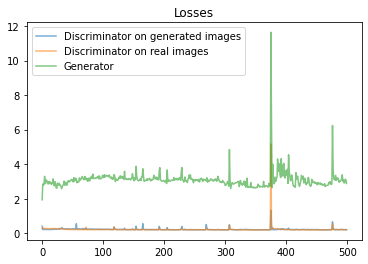

In [ ]:
d1_loss = [x[0] for x in data]
d2_loss = [x[1] for x in data]
g_loss = [x[2] for x in data]

fig, ax = plt.subplots()
plt.plot(d1_loss, label='Discriminator on generated images', alpha=0.6)
plt.plot(d2_loss, label='Discriminator on real images', alpha=0.6)
plt.plot(g_loss, label='Generator', alpha=0.6)
plt.title("Losses")
plt.legend()
